# Exercise 2

### 2.1 Which features are most suitable/influential in predicting wine quality? (Tip - You can consider feature importance ranking.)

Feature importance ranking (Ridge coefficients):
alcohol                 0.302385
volatile acidity        0.202462
sulphates               0.149031
total sulfur dioxide    0.091199
chlorides               0.080680
pH                      0.063453
fixed acidity           0.040579
density                 0.034246
citric acid             0.025511
free sulfur dioxide     0.024185
residual sugar          0.018499
dtype: float64

Correlation with quality:
quality                 1.000000
alcohol                 0.484866
sulphates               0.257710
citric acid             0.240821
fixed acidity           0.121970
Id                      0.069708
residual sugar          0.022002
pH                     -0.052453
free sulfur dioxide    -0.063260
chlorides              -0.124085
density                -0.175208
total sulfur dioxide   -0.183339
volatile acidity       -0.407394
Name: quality, dtype: float64


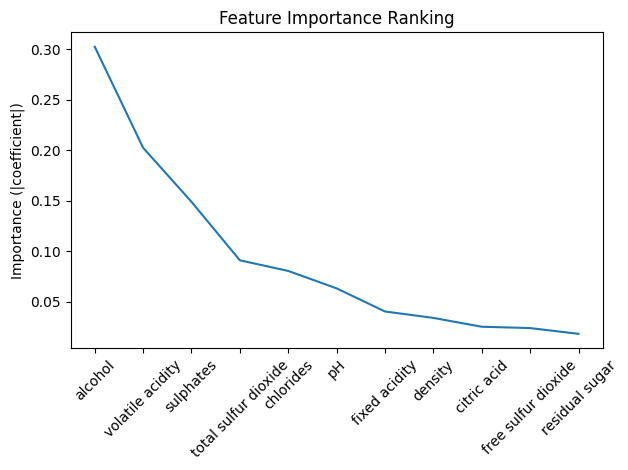

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Load dataset
df = pd.read_csv("../data/WineQT.csv")

# Features and target
X = df.drop(columns=["quality", "Id"])
y = df["quality"]

# Scale features to make coefficients comparable
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X) # calculate mean and std on full data and apply learned transformations to data

# Train Ridge regression. L2 regularization. Helps with multicollinearity. Adds penalty to large coefficients.
ridge = Ridge(alpha=1.0, random_state=42)
ridge.fit(X_scaled, y) # Learns weights (coefficients) that best predict y from X_scaled

# Collect feature importances
importance = pd.Series(np.abs(ridge.coef_), index=X.columns) # ridge.coef_ gives the learned coefficients. 
# Pandas Series to associate coefficients with feature names
importance = importance.sort_values(ascending=False)

print("Feature importance ranking (Ridge coefficients):")
print(importance)

# Also show correlation with quality
corr_matrix = df.corr(numeric_only=True)
print("\nCorrelation with quality:")
print(corr_matrix["quality"].sort_values(ascending=False))
plt.plot(importance.index, importance.values)
plt.xticks(rotation=45)
plt.ylabel("Importance (|coefficient|)")
plt.title("Feature Importance Ranking")
plt.tight_layout()
plt.show()


Ranked features using both correlation with quality and coefficients from a
Ridge regression model. The most influential features are **alcohol** (positive)
and **volatile acidity** (negative), followed by **sulphates** and **citric acid**.
Features such as **pH** and **density** show very little importance. This result
is consistent with previous correlation analysis, confirming that alcohol and
volatile acidity are the strongest predictors of wine quality.

### 2a

Polynomial regression: Extend the feature space to include quadratic or
interaction terms. Does this improve performance?

In [ ]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score

# Generating polynomial & interaction features in second degree
poly = PolynomialFeatures(degree=2, include_bias=False) # include_bias=False to avoid adding a column of ones
X_poly = poly.fit_transform(X)

# Scaling features. StandardScaler standardizes features by removing the mean and scaling to unit variance
scaler = StandardScaler() # Avoid large dominating values
X_poly_scaled = scaler.fit_transform(X_poly)

# 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42) 
mse_scores, rmse_scores, r2_scores = [], [], [] # To store metrics for each fold

for train_idx, test_idx in kf.split(X_poly_scaled): # Generate indices to split data into training and test set
    X_train, X_test = X_poly_scaled[train_idx], X_poly_scaled[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    model = Ridge(alpha=1.0, random_state=42) # Ridge regression model. Control overfitting since polynomial expansion creates many correlated features.
    model.fit(X_train, y_train) # Train model on training set
    
    y_pred = model.predict(X_test) # Predict wine quality on test set
    
    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    # Store metrics
    mse_scores.append(mse)
    rmse_scores.append(rmse)
    r2_scores.append(r2)

print("Polynomial Regression (degree = 2)")
print(f"MSE  = {np.mean(mse_scores):.4f} ± {np.var(mse_scores):.4f}")
print(f"RMSE = {np.mean(rmse_scores):.4f}")
print(f"R²   = {np.mean(r2_scores):.4f}")

Polynomial Regression (degree = 2)
MSE  = 0.4244 ± 0.0009
RMSE = 0.6510
R²   = 0.3424


Polynomial and interaction terms ($degree = 2$) were added to the feature space to
allow the model to capture nonlinear relationships. The Ridge regression model
achieved an average $R^2$ of $0.34$, compared to $0.30$ from the standard linear model,
indicating a modest improvement. The MSE of $0.42$ and RMSE of $0.65$ show that the
predictions are slightly more accurate and consistent across folds ($variance ≈ 0.001$).

This improvement suggests that certain nonlinear interactions such as those
between alcohol, acidity, and sulphates affect wine quality. However, the gain is
limited, meaning most relationships are still roughly linear or dominated by noise.


### 2b

Regularization: Train models using Ridge and Lasso regression. How do
these methods affect the coefficients and model generalization?

Ridge Regression:
MSE  = 0.4165 | RMSE = 0.6447 | R² = 0.3563

Lasso Regression:
MSE  = 0.4145 | RMSE = 0.6430 | R² = 0.3601
Non-zero coefficients: 6/11


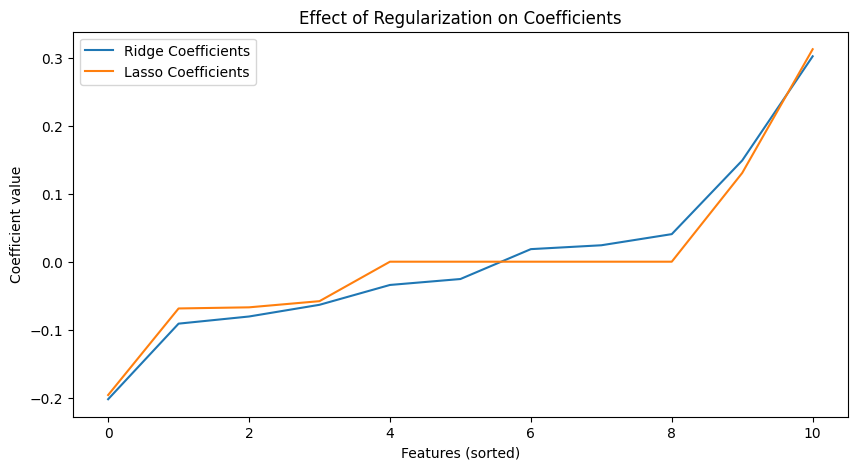

In [6]:
# Q2.2b Regularization: Ridge vs Lasso

from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold

# Use the same scaled features (X_scaled) and target (y) from before

kf = KFold(n_splits=5, shuffle=True, random_state=42)

def evaluate_reg(model, X_data, y_data): # Function to evaluate regression model with cross-validation
    mse_scores, rmse_scores, r2_scores = [], [], []
    for train_idx, test_idx in kf.split(X_data):
        X_train, X_test = X_data[train_idx], X_data[test_idx]
        y_train, y_test = y_data[train_idx], y_data[test_idx]

        model.fit(X_train, y_train) # Train model
        y_pred = model.predict(X_test)

        # Calculate metrics
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, y_pred)

        # Store metrics
        mse_scores.append(mse)
        rmse_scores.append(rmse)
        r2_scores.append(r2)

    return np.mean(mse_scores), np.mean(rmse_scores), np.mean(r2_scores)

# Ridge and Lasso models
ridge = Ridge(alpha=1.0, random_state=42) # L2 regularization. Shrinks coefficients but doesn't set to zero.
lasso = Lasso(alpha=0.01, random_state=42, max_iter=10000) # L1 regularization. Can set some coefficients to zero, performing feature selection.

# Evaluate both models
ridge_mse, ridge_rmse, ridge_r2 = evaluate_reg(ridge, X_scaled, y.values)
lasso_mse, lasso_rmse, lasso_r2 = evaluate_reg(lasso, X_scaled, y.values)

# Count non-zero coefficients for Lasso
lasso.fit(X_scaled, y)
nonzero = np.sum(lasso.coef_ != 0)

print("Ridge Regression:")
print(f"MSE  = {ridge_mse:.4f} | RMSE = {ridge_rmse:.4f} | R² = {ridge_r2:.4f}")

print("\nLasso Regression:")
print(f"MSE  = {lasso_mse:.4f} | RMSE = {lasso_rmse:.4f} | R² = {lasso_r2:.4f}")
print(f"Non-zero coefficients: {nonzero}/{X.shape[1]}")

# Visual comparison of coefficient magnitudes
ridge.fit(X_scaled, y)
ridge_coefs = pd.Series(ridge.coef_, index=X.columns)
lasso_coefs = pd.Series(lasso.coef_, index=X.columns)

plt.figure(figsize=(10,5))
plt.plot(ridge_coefs.sort_values().values, label='Ridge Coefficients')
plt.plot(lasso_coefs.sort_values().values, label='Lasso Coefficients')
plt.legend()
plt.title("Effect of Regularization on Coefficients")
plt.xlabel("Features (sorted)")
plt.ylabel("Coefficient value")
plt.show()


Ridge and Lasso regression were trained using 5-fold cross-validation on the
scaled dataset. Ridge achieved an $R^2$ of 0.356 and Lasso an $R^2$ of 0.360, both
slightly outperforming the standard linear and polynomial models. The average
RMSE of ~0.64 indicates that predictions deviate from true quality scores by
around 0.6 points on average.

The main difference lies in how the models treat feature coefficients. Ridge (L2
regularization) shrinks all coefficients but retains every feature, while Lasso (L1
regularization) set 5 of 11 coefficients exactly to zero, effectively performing
feature selection. This sparsity demonstrates that only a subset of features—such
as alcohol, volatile acidity, and sulphates—meaningfully contribute to predicting
wine quality.

Overall, regularization improved model generalization and stability by penalizing
large coefficients, reducing overfitting, and clarifying which features are most
important for prediction.


### 2c

Model comparison: Compare your linear regression results to a non-linear
model (e.g., Decision Tree or Random Forest). Which performs better, and
why?

Ridge Regression:
  MSE = 0.4165 | RMSE = 0.6447 | R² = 0.3563

Decision Tree:
  MSE = 0.5189 | RMSE = 0.7188 | R² = 0.1940

Random Forest:
  MSE = 0.3668 | RMSE = 0.6047 | R² = 0.4341


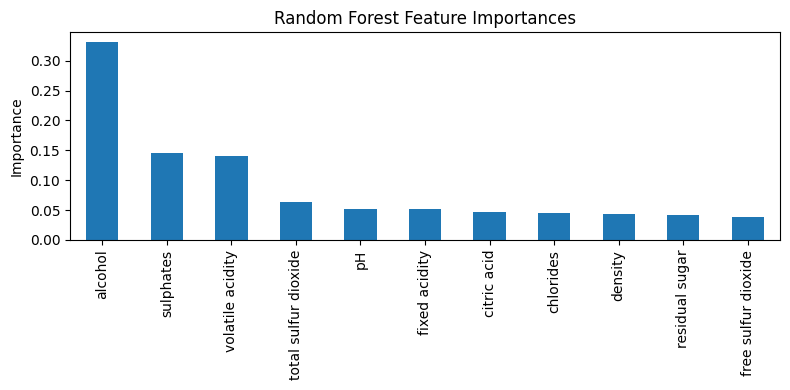

In [ ]:

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# Using same scaled features (X_scaled) and target (y)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

def evaluate_regressor(model, X_data, y_data): # Function to evaluate regression model with cross-validation
    mse_scores, rmse_scores, r2_scores = [], [], []
    for train_idx, test_idx in kf.split(X_data):
        X_train, X_test = X_data[train_idx], X_data[test_idx]
        y_train, y_test = y_data[train_idx], y_data[test_idx]

        # Fit model
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # Calculate metrics
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, y_pred)

        # Store metrics
        mse_scores.append(mse)
        rmse_scores.append(rmse)
        r2_scores.append(r2)

    return np.mean(mse_scores), np.mean(rmse_scores), np.mean(r2_scores)

# Models 
ridge = Ridge(alpha=1.0, random_state=42) # L2 regularization
tree = DecisionTreeRegressor(max_depth=6, random_state=42) # max_depth to prevent overfitting
forest = RandomForestRegressor(n_estimators=100, max_depth=8, random_state=42) # Ensemble of trees to reduce overfitting

# Evaluating models
ridge_mse, ridge_rmse, ridge_r2 = evaluate_regressor(ridge, X_scaled, y.values)
tree_mse, tree_rmse, tree_r2 = evaluate_regressor(tree, X_scaled, y.values)
forest_mse, forest_rmse, forest_r2 = evaluate_regressor(forest, X_scaled, y.values)

print("Ridge Regression:")
print(f"  MSE = {ridge_mse:.4f} | RMSE = {ridge_rmse:.4f} | R² = {ridge_r2:.4f}")

print("\nDecision Tree:")
print(f"  MSE = {tree_mse:.4f} | RMSE = {tree_rmse:.4f} | R² = {tree_r2:.4f}")

print("\nRandom Forest:")
print(f"  MSE = {forest_mse:.4f} | RMSE = {forest_rmse:.4f} | R² = {forest_r2:.4f}")

# Feature importance plot for the Random Forest
forest.fit(X_scaled, y)
importances = pd.Series(forest.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(8,4))
importances.plot(kind="bar") # Bar plot of feature importances
plt.title("Random Forest Feature Importances") 
plt.ylabel("Importance")
plt.tight_layout()
plt.show()


A linear Ridge model was compared with two non-linear alternatives: a Decision
Tree and a Random Forest, using 5-fold cross-validation. The Ridge model achieved
an $R^2$ of 0.36, the Decision Tree 0.19, and the Random Forest 0.43, confirming that
non-linear models capture more structure in the data.

The Decision Tree underperformed due to overfitting—learning very specific
thresholds that do not generalize well to unseen samples. In contrast, the Random
Forest averaged many randomized trees, reducing variance and improving
generalization. The resulting $R^2$ increase from 0.36 to 0.43 demonstrates that wine
quality depends on non-linear interactions between features.

The Random Forest feature importance plot shows that alcohol, sulphates, and
volatile acidity are the dominant predictors of wine quality, consistent with earlier
linear analyses. Overall, the Random Forest performed best because it captures
non-linear and interaction effects without assuming a fixed linear relationship,
while maintaining stability through ensemble averaging.
